# Mini Project 1: Reading in initial weights for the first hidden layer

As explained in the pdf for this project, we need to look at an alphanumeric edge detection program (using ANN(s) as per the project specifications) in order to read ingredients lists. This notebook will look into our approach using python in order to setup the initial weights and read in the images we wish to train on. 

The main weights we are concerned about are the ones linking the pixel features to the first hidden layer. Whilst usually all the weights are randomised, we are specifically investigating the effects of initially specialising the nodes in the first hidden layer to detect certain regions of the 60x60 pixel grid.

The hypothesis is edge detection can occur using positive weights in regions where white pixels are to be located, and negative weights where black pixels are located. But what is the easiest way to code these initial weights? This section is dedicated to the attempts at reading in the initial weights for the first hidden layer. 

## Attempt 1: GUI using tkinter
To me, this is the simplest way of programming a region of positive and negative weights. I did not have much familiarity with coding GUI in python, so I started by programming a simple GUI that has the following functions:

1) Generate a GUI of 60x60 buttons (each button representing a pixel on the grid).

2) Each button by default is 'off'. When clicked once, it sets the value of the weight at that pixel location to +1. When clicked twice, it sets the value of the weight at that pixel location to -1. When clicked thrice, it turns off.

3) After the buttons are pressed as desired, the tkinter interface can be closed, and the weights are saved as a 1D array corresponding to the number of button clicks. 

### Imports

In [1]:
'''
Program used to generate the initial weights via a GUI interaction. The
GUI appears, and the user can assign positive and negative initial
weights to specific pixels on the grid.
'''
import tkinter as tk
import numpy as np
from enum import Enum 

### Click function

In [2]:
class ClickState(Enum):
    '''
    This class gives us a way of labelling the click states
    that is more readable.
    
    OFF (0) represents an unclicked button, and is the
    default option.
    POSITIVE (1) represents a button clicked once. This will
    attribute a positive weight to the weights at the end of the code.
    NEGATIVE (-1) represents a button clicked twice. This will
    attribute a negative weight to the weights at the end of the code.
    '''
    
    OFF = 0
    POSITIVE = 1
    NEGATIVE = -1
    
def click(x_val,y_val, grid_var, click_state):
    '''
    Uses the global grid buttons and a state changer to change the GUI
    if a button has been pressed.

    When clicked, the states will go through a cycle:

    off -> positive -> negative -> off
    '''

    # This state cycle engine will go from the current state when
    # the button is clicked, to the next state. The if conditions
    # represent the current state when clicked, and the statements
    # within represent the transition to the next state.
    if click_state[x_val][y_val] == ClickState.NEGATIVE.value:
        # Changing the button on the GUI
        grid_var[x_val][y_val].config(bg = 'SystemButtonFace', text = '')
        # Changing the click_state
        click_state[x_val][y_val] = ClickState.OFF.value

    elif click_state[x_val][y_val] == ClickState.OFF.value:
        # Changing the button on the GUI
        grid_var[x_val][y_val].config(bg = 'cyan', text = '+')
        # Changing the click_state
        click_state[x_val][y_val] = ClickState.POSITIVE.value

    elif click_state[x_val][y_val] == ClickState.POSITIVE.value:
        # Changing the button on the GUI
        grid_var[x_val][y_val].config(bg = 'red', text = '-')
        # Changing the click_state
        click_state[x_val][y_val] = ClickState.NEGATIVE.value

### GUI

In [3]:
def run_ini_weights_gui(n_x = 60, n_y = 60, tol_var = 1E-6):
    '''
    Runs the GUI for setting the initial weights. Uses the click(x,y)
    function defined above.
    '''

    # grid_var is a list of buttons.
    grid_var = [[0 for i in range(n_x)] for j in range(n_y)]
    click_state = [[ClickState.OFF.value for i in range(n_x)] for j in range(n_y)]
    root = tk.Tk()

    # Iterating over the rows and columns.
    for row_val in range(n_x):
        for col_val in range(n_y):
            grid_var[row_val][col_val] = tk.Button(root,command = lambda
            x = row_val, y = col_val : click(x,y,grid_var,click_state),
            height = 1, width = 1)
            # Placing the button on the grid.
            grid_var[row_val][col_val].grid(row = row_val, column = col_val)

    root.mainloop()
    # The initial weights for now are just an array of click_state.
    ini_weights = np.array(click_state, dtype = np.float_)
    # Reshaping into a 1D array. The .flatten() method returns a copy, and
    # does not perform the flattening in place!
    ini_weights = ini_weights.flatten()
    del grid_var, row_val, col_val, root, click_state

    # Since weights that are zero will not change via back-propagation,
    # we assign weights with absolute values less than tol_var as equal to that tolerance.
    # This will allow them to change as the ANN learns.
    for index, weight in enumerate(ini_weights):
        if abs(weight) < tol_var:
            ini_weights[index] = tol_var

    return ini_weights

### Main code

In [4]:
WEIGHTS = run_ini_weights_gui()
# Printing the first 10 elements of the WEIGHTS array.
for INDEX, WEIGHT in enumerate(WEIGHTS):
    if INDEX > 9:
        break
    print('i = {}, weight = {}'.format(INDEX, WEIGHT))

i = 0, weight = 1.0
i = 1, weight = 1.0
i = 2, weight = 1.0
i = 3, weight = -1.0
i = 4, weight = -1.0
i = 5, weight = -1.0
i = 6, weight = 1e-06
i = 7, weight = 1.0
i = 8, weight = 1e-06
i = 9, weight = -1.0


### Discussion
The code works as expected, and the run_ini_weights_gui() function can be called as many times as there are nodes. We can also save a config file for each node, and check if it exists using imported os commands such as os.path.exists() on the config file name. This will save us from having to re-initialise all of the node weights if we do not wish to. 

However, the GUI is cumbersome. Since the click function is only called via clicking the button, it means that each individual pixel must be clicked the desired number of times in order to assign it. Also, the loading times for the GUI are undesirably slow. This is a lot of time spent assigning the initial weights that can be better spent elsewhere. Granted - python is not known amongst the other languages for speed, but we would like to think of more efficient ways to use python as part of the creative challenge of the project specifications!

## Attempt 2: Using MS Paint's GUI and image imports

Whilst I was clicking away at the GUI, I was thinking about how much of MS Paint's GUI that I take for granted. The ability to use drag click alone saves a lot of time, and at least initially it would seem very complicated to try and introduce that kind of functionality into a tkinter GUI.

The beautiful thing about python is that with all of its cross talking between different input types and libraries, I did not have to re-invent the MS Paint GUI using tkinter. A brilliant idea came to me: why not just create images using the MS Paint GUI, import them into python, and then convert the pixel data of that image into a set of weights?

For this algorithm, we have the following steps:

1) Read in a 60x60 pixel image file with a black background, with cyan corresponding to positive weights and red to negative (as per our original, colourblind appropriate colour scheme in the pdf).

2) Iterate over the pixels, and convert the pixels into weights. If the colour is cyan, convert to +1, if red, convert to -1, and if black/white convert to 0. 

3) Produce a 1D weight array corresponding to all of the pixels in the grid.

For step 2), I will have to go into a little bit of colour theory.

### Imports (some are used for the colour theory explanation, so I put them all here for convenience)

In [5]:
import os
import math as m
from PIL import Image

### Colour theory

I want to design a map that takes the pixel colour values to a weighting. As per my chosen colour scheme, I want cyan to map to a weight of +1, and red to -1, to represent the positive and negative weights. This can be done by expressing the colours as 2D vectors in the xy plane.

Below is a diagram of the coordinate system that I am using. Here, I have aligned the x-axis along the colour cyan. 

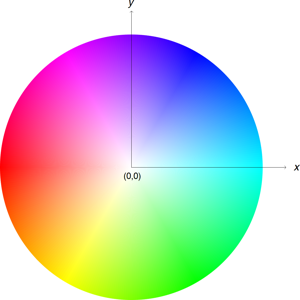

In [6]:
# Opening the image about colour theory.
colour_theory_image = Image.open('colour_wheel_cyan_vectors.png')
colour_theory_image.resize((300,300))

# CAPTION: Colour wheel with the colour cyan aligned with the x-axis.
# Red is along the negative x-axis, and the green and blue vectors are 300 and 60 degrees respectively
# from the positive x-axis.

# Adapted from https://commons.wikimedia.org/w/index.php?curid=92880308 under license CC BY-SA 4.0.

In this coordinate system, we express the unit vectors for the red, green and blue colours as

$$
\hat{\textbf{R}} = \begin{bmatrix}
-1 \\
0
\end{bmatrix},
\ \hat{\textbf{G}} = \begin{bmatrix}
\cos(300 \text{°}) \\
\sin(300 \text{°}) 
\end{bmatrix} = \frac{1}{2}\begin{bmatrix}
1 \\
-\sqrt{3} 
\end{bmatrix},
\ \hat{\textbf{B}} = \begin{bmatrix}
\cos(60 \text{°}) \\
\sin(60 \text{°}) 
\end{bmatrix} = \frac{1}{2}\begin{bmatrix}
1 \\
\sqrt{3} 
\end{bmatrix},
$$

where $\hat{\textbf{R}}, \hat{\textbf{G}}$ and $\hat{\textbf{B}}$ are the unit vectors in the red, green and blue directions respectively. When we look at a pixel using python, it gives us a tuple containing the red, green and blue content of the pixel, which just tells us the amount of the unit vectors $\hat{\textbf{R}}, \hat{\textbf{G}}$ and $\hat{\textbf{B}}$ that we have in that pixel. If we label the pixel tuple as $(R,G,B)$, then we express the colour vector $\textbf{C}_{R,G,B}$ in our coordinate system as

$$
\textbf{C}_{R,G,B} = \frac{R\cdot\hat{\textbf{R}} + G\cdot\hat{\textbf{G}} + B\cdot\hat{\textbf{B}}}{255}.
$$

The division by 255 ensures that cyan maps to $\begin{bmatrix}1 \\ 0 
\end{bmatrix}$, and red to $\begin{bmatrix} -1 \\ 0 
\end{bmatrix}$. Both white and black in this instance map to $\begin{bmatrix}0 \\ 0 
\end{bmatrix}$. Since we only plan on using cyan and red to represent positive and negative weights respectively, we can take the x-component of the vector $\textbf{C}_{R,G,B}$ as the value of our weight. The code for this is shown below.

### Pixels to weight function

In [7]:
def pixel_to_weight(pixel_colours, tol_var = 1E-6):
    '''
    Coverts a single pixel tuple into a weight for the initial weighting.
    Acceptable colours are cyan for positive weights, red for negative
    weights, and black for 0.

    This function converts the red, green and blue values into 2D
    vectors, where the x-axis is aligned along the cyan axis. So purely
    red maps to a vector of (-1,0), and purely cyan to (1,0).
    The weight is taken as the value of the x-component, provided that the
    absolute value of the x-component is greater than the tolerance tol_var.
    '''

    global RED_UNIT_VEC, GREEN_UNIT_VEC, BLUE_UNIT_VEC

    # The colour vector is the sum of the colour components.
    colour_vec = (pixel_colours[0]*RED_UNIT_VEC + \
    pixel_colours[1]*GREEN_UNIT_VEC + \
    pixel_colours[2]*BLUE_UNIT_VEC) \
    /(255.0)

    # The weights will not change if the baseline level is too
    # low in absolute value, so we pick a tolerance. If the
    # absolute value of the x component is less than the tolerance,
    # then we assign the weight to the tolerance multiplied by the
    # sign of the x component. Else, we just assign the weight to the
    # x component.
    if abs(colour_vec[0]) > tol_var:
        return colour_vec[0]
    return np.sign(colour_vec[0])*tol_var

I will now test this code using some other functions that will be useful later on. Using the weights that we generated, I will look at two things:

1) The results of the basic colours/shades using the function pixel_to_weight().

2) The result of a function that transforms the weights back into the pixel contents, and re-draws the image.

The latter requires a function that takes the weights, which is just the x-component of the vector $\textbf{C}_{R,G,B}$, and returns the equivalent amount of cyan or red depending on whether or not the input weight is postive or negative respectively. Note that this does NOT map back to the original vector $\textbf{C}_{R,G,B}$, which could be any colour, but rather just converts that vector into a new vector $\textbf{C}^{'}_{R,G,B}$ which scales from cyan to red.

### Weights to pixels function, which depends on the smaller weight to pixel function

In [8]:
def weights_to_pixels(weights,out_filename):
    '''
    This is a function that takes in the weights of a single node in
    the first hidden layer, and changes them into an image. This should
    be used to test the output of the pixel_to_weight() method above,
    but it can also be used to generate pictures of the distribution of
    weights after the ANN has converged.
    '''

    global N_X, N_Y

    # On input, weights are a 1D array or list. We can reshape it into
    # a 2D array in order for easier indexing.
    weights_2d = np.array(weights).reshape((N_X,N_Y))
    out_image = Image.new('RGB', (N_X,N_Y), 'white')
    pixels_var = out_image.load()

    # Now iterating over the width and height.
    for i in range(N_X):
        for j in range(N_Y):
            pixels_var[i,j] = weight_to_pixel(weights_2d[i,j])

    # Now we can save to the desired output name.
    out_image.save(out_filename)
    del out_image, pixels_var, weights_2d
    return 'WEIGHTS TO PIXELS COMPLETE\n'

def weight_to_pixel(weight_var, accur_var = 14):
    '''
    This function converts a singular weight value to a pixel.
    Rounding is necessary to map cyan to the proper pixel value.
    accur_var controls the accuracy of the round() method.
    '''

    # If the weight is less than or equal to zero, then we take the
    # absolute value of that weight in terms of red.
    # If the weight is greater than zero, then we take the value of the
    # weight in terms of cyan.
    if weight_var <= 0:
        return (int(255*abs(round(weight_var,accur_var))),0,0)
    return (0,int(255*round(weight_var,accur_var)),\
                int(255*round(weight_var,accur_var)))

### Test functions

In [9]:
def colour_test():
    '''
    This function tests the values of the functions pixel_to_weight()
    and weight_to_pixel() for some basic colours/shades.
    '''

    global COLOUR_DICT

    # Testing values of the pixel function to show the forward and the
    # inverse mapping.
    print('\nTESTING VALUES OF pixel_to_weight() AND THEN \
weight_to_pixel() OF VARIOUS COLOURS/shades: \n')

    count = 0
    x_max = 2
    y_max = len(COLOUR_DICT)
    dpixels = 60

    test_image = Image.new('RGB', (x_max*dpixels,
    y_max*dpixels), 'white')
    test_pixels = test_image.load()

    # Iterating over the colour dictionary.
    for colour in COLOUR_DICT.keys():
        weight_temp = pixel_to_weight(COLOUR_DICT[colour])
        pixel_temp = weight_to_pixel(weight_temp)
        print('COLOUR = {}:\n'.format(colour))
        print('ORIGINAL PIXEL = {}, WEIGHT = {}, NEW PIXEL \
= {}\n'.format(COLOUR_DICT[colour], weight_temp, pixel_temp))

        # Now showing the comparison between the pixels on the test
        # image strip. The left most block are the original colours,
        # and the right most block are the projected colours onto the
        # x-axis.
        for i_val in range(0,x_max*dpixels):
            for j_val in range(count*dpixels,(count+1)*dpixels):
                if i_val < dpixels:
                    test_pixels[i_val, j_val] = COLOUR_DICT[colour]
                else:
                    test_pixels[i_val, j_val] = pixel_temp
        count += 1

    del weight_temp, pixel_temp, count
    return test_image

def readin_readout_test():
    '''
    Test function to show that the read-in of the weights from an input
    image and the output image are the same. This can be shown by
    visually comparing images test_weights.png and test_weights_out.png
    '''

    global N_X, N_Y
    weights = []

    # Reading in the test image.
    in_filename = os.getcwd()
    in_filename += '\\ini_weights\\input_weights_test_images\\test_weights.png'
    in_image = Image.open(in_filename)
    in_pixels = in_image.load()

    # If the sizes match the hardcoded values, then we can comfortably
    # iterate over the pixels to get the weights.
    if in_image.size[0] == N_X and in_image.size[1] == N_Y:
        for x_val in range(N_X):
            for y_val in range(N_Y):
                weights.append(pixel_to_weight(in_pixels[x_val,y_val]))

        # Now we prepare the output filename.
        out_filename = os.getcwd()
        out_filename += '\\ini_weights\\input_weights_test_images\\test_weights_out.png'
        print(weights_to_pixels(weights,out_filename))
        return 'READIN READOUT TEST COMPLETE\n'

    print('ERROR: size of input image does not match dimensions of\
grid. N_X = {}, N_Y = {}'.format(N_X,N_Y))
    return 'READIN READOUT TEST INCOMPLETE\n'

### Main code

In [10]:
# The cyan unit vector is aligned along the x-axis, therefore red is
# aligned along the negative x-axis.
# The green and blue unit vectors are 300 and 60 degrees from the
# positive x-axis respectively.
THETA = m.radians(60.0)
RED_UNIT_VEC = np.array([-1,0])
GREEN_UNIT_VEC = np.array([np.cos(5.0*THETA),np.sin(5.0*THETA)])
BLUE_UNIT_VEC = np.array([np.cos(THETA),np.sin(THETA)])
del THETA

# N_X, N_Y is the size of the grid in the x and y directions
# respectively.
N_X = 60
N_Y = 60

# Building the colour dictionary of test colours/shades.
COLOUR_DICT = {'RED':(255,0,0),'GREEN':(0,255,0),'BLUE':(0,0,255),
'CYAN':(0,255,255),'MAGENTA':(255,0,255),'YELLOW':(255,255,0),
'WHITE':(255,255,255),'BLACK':(0,0,0), 'GREY':(127,127,127)}

TEST_IMAGE = colour_test()
del COLOUR_DICT

print(readin_readout_test())
del RED_UNIT_VEC, GREEN_UNIT_VEC, BLUE_UNIT_VEC, N_X, N_Y


TESTING VALUES OF pixel_to_weight() AND THEN weight_to_pixel() OF VARIOUS COLOURS/shades: 

COLOUR = RED:

ORIGINAL PIXEL = (255, 0, 0), WEIGHT = -1.0, NEW PIXEL = (255, 0, 0)

COLOUR = GREEN:

ORIGINAL PIXEL = (0, 255, 0), WEIGHT = 0.49999999999999933, NEW PIXEL = (0, 127, 127)

COLOUR = BLUE:

ORIGINAL PIXEL = (0, 0, 255), WEIGHT = 0.5000000000000001, NEW PIXEL = (0, 127, 127)

COLOUR = CYAN:

ORIGINAL PIXEL = (0, 255, 255), WEIGHT = 0.9999999999999994, NEW PIXEL = (0, 255, 255)

COLOUR = MAGENTA:

ORIGINAL PIXEL = (255, 0, 255), WEIGHT = -0.4999999999999999, NEW PIXEL = (127, 0, 0)

COLOUR = YELLOW:

ORIGINAL PIXEL = (255, 255, 0), WEIGHT = -0.5000000000000007, NEW PIXEL = (127, 0, 0)

COLOUR = WHITE:

ORIGINAL PIXEL = (255, 255, 255), WEIGHT = -1e-06, NEW PIXEL = (0, 0, 0)

COLOUR = BLACK:

ORIGINAL PIXEL = (0, 0, 0), WEIGHT = 0.0, NEW PIXEL = (0, 0, 0)

COLOUR = GREY:

ORIGINAL PIXEL = (127, 127, 127), WEIGHT = -1e-06, NEW PIXEL = (0, 0, 0)

WEIGHTS TO PIXELS COMPLETE

READIN REA

### Inputs and outputs
We had an input file called test_weights.png, which shows an example of weights that may be used. The image was generated using the MS Paint GUI. The above code uses the test functions to map the input image to weights, and then the weights to an output image called test_weights_out.png. 

TEST_IMAGE shows the result of taking some basic colours/shades, and taking them through this process. The colours on the left are the original colours used, and on the right are the projections of that colour on our cyan-red x-axis. Firstly, red and cyan map to each other as expected. Green and blue have a weight of approximately 0.5, which maps to a darker shade of cyan. Yellow and magenta have a weight of approximately -0.5, which maps to a darker shade of red. All shades of white map to black using this procedure, because the weight is approximately 0. 

What this tells us is that we can use the weights_to_pixels() function to create colour maps showing the value of the weights (provided of course they are normalised using their maximum value). This will be used to test what happens to our initialised nodes after the ANN has converged, to see to what extent the weights change from their initial configuration. 

The last two cells compare test_weights.png and test_weights_out.png, which shows good and expected replication of the data using the functions. Therefore, we can draw the initial weights using the superior MS Paint GUI for better replication of the results.

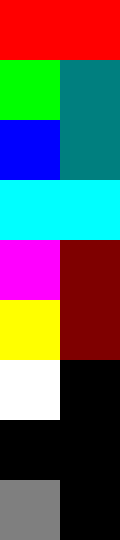

In [11]:
TEST_IMAGE

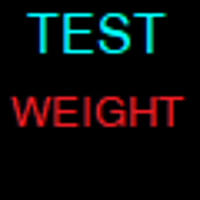

In [12]:
in_filename = os.getcwd()
in_filename += '\\ini_weights\\input_weights_test_images\\test_weights.png'
in_image = Image.open(in_filename)
in_image.resize((200,200))

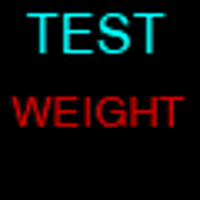

In [13]:
out_filename = os.getcwd()
out_filename += '\\ini_weights\\input_weights_test_images\\test_weights_out.png'
out_image = Image.open(out_filename)
out_image.resize((200,200))

## Conclusion
I set out to create a GUI that can allow one to set the initial weights for the ANN. I found that the python widget based GUIs to be too cumbersome for our purposes here, and therefore opted to choose an already optimised GUI in terms of user experience, and port the outputs to files that python can use. I chose MS Paint since it is either already installed or available for installation on all Windows PCs, but any GUI that can create colour image files will suffice. This drastically reduces the time spent on generating the initial weights for the ANN developer.

I demonstrated that the initial weights could be read in via an image, and then converted back into the original image using the inverse of the function (for certain choices of colours used in the initial image, namely if the initial image contains cyan and red as the only non-white colours). These functions have successfully passed all tests and are suitable for the purpose they were created for.